In [1]:
import deepdish as dd
import pandas as pd
import os
import numpy as np

In [2]:
dataf="/mnt/lab_data2/anusri/chrombpnet/logs/checkpoint/JAN_02_2023/model_dir_atac.csv"

In [3]:
data = pd.read_csv(dataf, sep=",", header=None)

In [4]:
data[data[1]=="GM12878"][2]

0    /mnt/lab_data2/anusri/chrombpnet/results/chrom...
1    /oak/stanford/groups/akundaje/projects/chromat...
2    /oak/stanford/groups/akundaje/projects/chromat...
3    /oak/stanford/groups/akundaje/projects/chromat...
4    /oak/stanford/groups/akundaje/projects/chromat...
Name: 2, dtype: object

In [5]:
cell_typs = ["H1ESC", "GM12878", "HEPG2", "IMR90", "K562"]


In [6]:
itype="counts"
scores_array = {"ATAC":{}, "DNASE":{}}
for cell_type in cell_typs:
    print(cell_type)
    dtypes=["ATAC", "DNASE"]
    for dtype in dtypes:
        print(dtype)
        merged_regions = "/oak/stanford/groups/akundaje/projects/chromatin-atlas-2022/chrombpnet/folds/"+dtype+"/"+cell_type+"/merge_folds_new/"+cell_type+"_folds_merged."+itype+"_scores_new_compressed.h5"
        merged_scores = dd.io.load(merged_regions, '/projected_shap/seq')
        if dtype=="ATAC":
            index = np.random.choice(merged_scores.shape[0], 30000, replace=False)
            dataf="/mnt/lab_data2/anusri/chrombpnet/logs/checkpoint/JAN_02_2023/model_dir_atac.csv"
            data = pd.read_csv(dataf, sep=",", header=None)
        else:
            dataf="/mnt/lab_data2/anusri/chrombpnet/logs/checkpoint/JAN_02_2023/model_dir_dnase.csv"
            data = pd.read_csv(dataf, sep=",", header=None)
            
            
        mean_deepshap = np.sum(merged_scores[index,:,1057-500:1057+500],axis=1)
        if cell_type not in  scores_array[dtype]:
             scores_array[dtype][cell_type] = []
        
        scores_array[dtype][cell_type].append(mean_deepshap) 
        
        one_hots=None
        for i,r in data[data[1]==cell_type].iterrows():
            print(i)
            ppath = os.path.join(r[2],"chrombpnet_model/interpret/full_"+cell_type+"."+itype+"_scores_new_compressed.h5")
            if os.path.exists(ppath):
                    scores = dd.io.load(ppath, '/shap/seq')[index,:,1057-500:1057+500]
                    if one_hots is  None:
                        one_hots = dd.io.load(ppath, '/raw/seq')[index,:,1057-500:1057+500]
                    scores = scores*one_hots
            elif os.path.exists(os.path.join(r[2],"interpret/merged."+cell_type+"."+itype+"_scores_new_compressed.h5")):
                    ppath = os.path.join(r[2],"interpret/merged."+cell_type+"."+itype+"_scores_new_compressed.h5")
                    scores = dd.io.load(ppath, '/shap/seq')[index,:,1057-500:1057+500]
                    if one_hots is  None:
                        one_hots = dd.io.load(ppath, '/raw/seq')[index,:,1057-500:1057+500]
                    scores = scores*one_hots
            else:
                    ppath = os.path.join(r[2],"chrombpnet_model/interpret/full_"+cell_type+"."+itype+"_scores_new_compressed.h5")
                    scores = dd.io.load(ppath, '/shap/seq')[index,:,1057-500:1057+500]
                    if one_hots is  None:
                        one_hots = dd.io.load(ppath, '/raw/seq')[index,:,1057-500:1057+500]
                    scores = scores*one_hots
            vals = np.sum(scores,axis=1)
            scores_array[dtype][cell_type].append(vals)

    
    

H1ESC
ATAC
20
21
22
23
24
DNASE
20
21
22
23
24
GM12878
ATAC
0
1
2
3
4
DNASE
0
1
2
3
4
HEPG2
ATAC
10
11
12
13
14
DNASE
10
11
12
13
14
IMR90
ATAC
15
16
17
18
19
DNASE
15
16
17
18
19
K562
ATAC
5
6
7
8
9
DNASE
5
6
7
8
9


H1ESC
0
1
2
3
4
GM12878
0
1
2
3
4
HEPG2
0
1
2
3
4
IMR90
0
1
2
3
4
K562
0
1
2
3
4


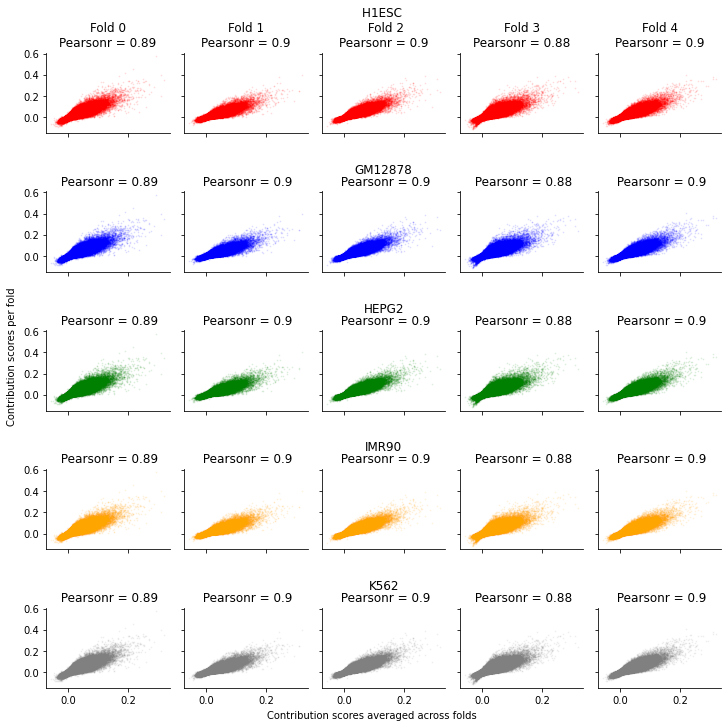

In [7]:
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42 
from matplotlib.gridspec import SubplotSpec

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str, j: int):
    "Sign sets of subplots with title"
   
    row = fig.add_subplot(grid)
    # the '\n' is important
    if j!=0:
        row.set_title(f'{title}\n', pad=0)
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')
    
fig, axs = plt.subplots(nrows=5,ncols=5,figsize=(10,10), sharex=True, sharey=True)
dtype="ATAC"
idx=0
colors = ["red", "blue", "green", "orange", "grey"]
for cell_typ in cell_typs:
    print(cell_typ)
    mean_deepshap = scores_array[dtype][cell_type][0]
    for i in range(5):
        print(i)
        if idx==0:
            val = scores_array[dtype][cell_type][i+1]
            if i==2:
                axs[idx,i].scatter(mean_deepshap.flatten(), val.flatten(), alpha=0.1, s=0.5, c=colors[idx], rasterized=True)
                axs[idx,i].set_title("H1ESC \n Fold "+str(i)+"\n"+"Pearsonr = "+str(np.round(scipy.stats.pearsonr(mean_deepshap.flatten(), val.flatten())[0],2)))           
            else:
                axs[idx,i].scatter(mean_deepshap.flatten(), val.flatten(), alpha=0.1, s=0.5, c=colors[idx], rasterized=True)
                axs[idx,i].set_title("Fold "+str(i)+"\n"+"Pearsonr = "+str(np.round(scipy.stats.pearsonr(mean_deepshap.flatten(), val.flatten())[0],2)))           
        else:
            val = scores_array[dtype][cell_type][i+1]
            axs[idx,i].scatter(mean_deepshap.flatten(), val.flatten(), alpha=0.1, s=0.5, c=colors[idx], rasterized=True)
            axs[idx,i].set_title(" Pearsonr = "+str(np.round(scipy.stats.pearsonr(mean_deepshap.flatten(), val.flatten())[0],2)))
        axs[idx,i].spines['top'].set_visible(False)
        axs[idx,i].spines['right'].set_visible(False)
    idx = idx+1

grid = plt.GridSpec(5, 5)
for j in range(5):
    create_subtitle(fig, grid[j, ::], cell_typs[j], j)
fig.tight_layout()

fig.text(0.5, 0, 'Contribution scores averaged across folds', ha='center', va='center')
fig.text(0, 0.5,'Contribution scores per fold', ha='center', va='center', rotation='vertical')

plt.savefig(itype+"_"+dtype+"_deepshap_all.pdf", transparent=True, dpi=300 )


H1ESC
0
1
2
3
4
GM12878
0
1
2
3
4
HEPG2
0
1
2
3
4
IMR90
0
1
2
3
4
K562
0
1
2
3
4


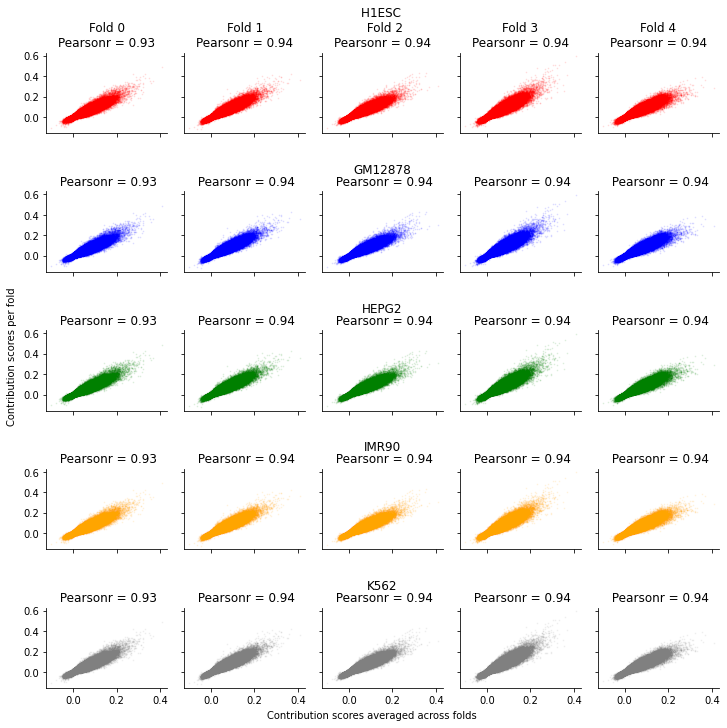

In [8]:
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42 
from matplotlib.gridspec import SubplotSpec

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str, j: int):
    "Sign sets of subplots with title"
   
    row = fig.add_subplot(grid)
    # the '\n' is important
    if j!=0:
        row.set_title(f'{title}\n', pad=0)
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')
    
fig, axs = plt.subplots(nrows=5,ncols=5,figsize=(10,10), sharex=True, sharey=True)
dtype="DNASE"
idx=0
colors = ["red", "blue", "green", "orange", "grey"]
for cell_typ in cell_typs:
    print(cell_typ)
    mean_deepshap = scores_array[dtype][cell_type][0]
    for i in range(5):
        print(i)
        if idx==0:
            val = scores_array[dtype][cell_type][i+1]
            if i==2:
                axs[idx,i].scatter(mean_deepshap.flatten(), val.flatten(), alpha=0.1, s=0.5, c=colors[idx], rasterized=True)
                axs[idx,i].set_title("H1ESC \n Fold "+str(i)+"\n"+"Pearsonr = "+str(np.round(scipy.stats.pearsonr(mean_deepshap.flatten(), val.flatten())[0],2)))           
            else:
                axs[idx,i].scatter(mean_deepshap.flatten(), val.flatten(), alpha=0.1, s=0.5, c=colors[idx], rasterized=True)
                axs[idx,i].set_title("Fold "+str(i)+"\n"+"Pearsonr = "+str(np.round(scipy.stats.pearsonr(mean_deepshap.flatten(), val.flatten())[0],2)))           
        else:
            val = scores_array[dtype][cell_type][i+1]
            axs[idx,i].scatter(mean_deepshap.flatten(), val.flatten(), alpha=0.1, s=0.5, c=colors[idx], rasterized=True)
            axs[idx,i].set_title(" Pearsonr = "+str(np.round(scipy.stats.pearsonr(mean_deepshap.flatten(), val.flatten())[0],2)))
        axs[idx,i].spines['top'].set_visible(False)
        axs[idx,i].spines['right'].set_visible(False)
    idx = idx+1

grid = plt.GridSpec(5, 5)
for j in range(5):
    create_subtitle(fig, grid[j, ::], cell_typs[j], j)
fig.tight_layout()

fig.text(0.5, 0, 'Contribution scores averaged across folds', ha='center', va='center')
fig.text(0, 0.5,'Contribution scores per fold', ha='center', va='center', rotation='vertical')

plt.savefig(itype+"_"+dtype+"_deepshap_all.pdf", transparent=True, dpi=300 )
